## DATASET

In [ ]:
import numpy as np
from tensorflow.keras.datasets import mnist, fashion_mnist
import matplotlib.pyplot as plt

Loading the MNIST and Fashion MNIST dataset

In [ ]:
(mnist_x_train, mnist_y_train), (mnist_x_test, mnist_y_test) = mnist.load_data()
(fashion_mnist_x_train, fashion_mnist_y_train), (fashion_mnist_x_test, fashion_mnist_y_test) = fashion_mnist.load_data()
print()

print('Shape MNIST train:', np.shape(mnist_x_train))
print('Shape Fashion MNIST train:', np.shape(fashion_mnist_x_train))
print()

# Normalization and Padding
mnist_x_train = np.pad(mnist_x_train,((0,0),(2,2),(2,2)))/255.
mnist_x_test = np.pad(mnist_x_test,((0,0),(2,2),(2,2)))/255.
print('Shape MNIST train after padding:', np.shape(mnist_x_train))
fashion_mnist_x_train = np.pad(fashion_mnist_x_train,((0,0),(2,2),(2,2)))/255.
fashion_mnist_x_test = np.pad(fashion_mnist_x_test,((0,0),(2,2),(2,2)))/255.
print('Shape Fashion MNIST train after padding:', np.shape(mnist_x_train))


Shape MNIST train: (60000, 28, 28)
Shape Fashion MNIST train: (60000, 28, 28)

Shape MNIST train after padding: (60000, 32, 32)
Shape Fashion MNIST train after padding: (60000, 32, 32)


In [ ]:
print(f'Number of MNIST/fashion MNIST training samples: {np.shape(mnist_x_train)[0]}')
print(f'Number of MNIST/fashion MNIST test samples: {np.shape(mnist_x_test)[0]}')
print(f'MNIST/fashion MNIST resolution: {np.shape(mnist_x_test)[1:]}')

Number of MNIST/fashion MNIST training samples: 60000
Number of MNIST/fashion MNIST test samples: 10000
MNIST/fashion MNIST resolution: (32, 32)


Only one channel (grey-scale images).

In [ ]:
N_train, h, w = mnist_x_train.shape[0], mnist_x_train.shape[1], mnist_x_train.shape[2]
N_test = mnist_x_test.shape[0]

### Data generator
Generator which generates batches. A batch is a couple `x_batch, y_batch`, containing `batchsize` number of samples. `x_batch` represents the input, and it contains images `x`: each image `x` has spatial dimensions $32*32$ and it contains a pair of MNIST-fashion MNIST images added together. `y_batch` represents the ground truth, and it contains the images `y`: each image `y` has spatial dimensions $32*64$ and it contains the same pair of MNIST-fashion MNIST images concatenated along the width.

In [ ]:
def datagenerator(x1, x2, batchsize):
    # x1: first dataset of images. In our case, MNIST dataset (either train or test)
    # x2: second dataset of images. In our case, fashion MNIST dataset (either train or test)

    n1 = x1.shape[0]
    n2 = x2.shape[0]
    while True:
        num1 = np.random.randint(0, n1, batchsize)
        num2 = np.random.randint(0, n2, batchsize)

        x_batch = (x1[num1] + x2[num2]) / 2.0
        y_batch = np.concatenate((x1[num1], x2[num2]), axis=2)

        yield x_batch, y_batch 

In [ ]:
batchsize = 64

In [ ]:
# Generator for creating the training batches
train_generator = datagenerator(mnist_x_train, fashion_mnist_x_train, batchsize)

# Generator for creating the validation batches
test_generator = datagenerator(mnist_x_test, fashion_mnist_x_test, batchsize)

Example of a training batch

In [ ]:
x_batch, y_batch = next(train_generator)
print('Shape of the x_batch:', x_batch.shape)
print('Shape of the y_batch:', y_batch.shape)

Shape of the x_batch: (64, 32, 32)
Shape of the y_batch: (64, 32, 64)


The data is already normalized into $[0,1]$

In [ ]:
x_batch[0].min(), x_batch[0].max()

(0.0, 0.8313725490196078)

In [ ]:
y_batch[0].min(), y_batch[0].max()

(0.0, 1.0)

Visualization of a sample in the batch

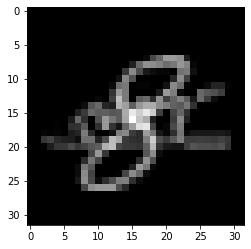

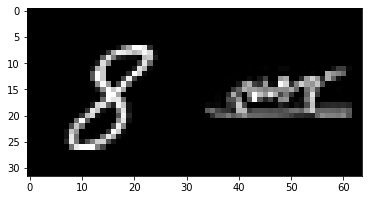

In [ ]:
x = x_batch[0]  # Input
y = y_batch[0]  # Ground truth
plt.imshow(x,cmap='gray', interpolation='nearest')
plt.show()
plt.imshow(y, cmap='gray', interpolation='nearest')
plt.show()

## MODEL
U-net of the same structure of the previous notebook (single branch, producing only the fashion MNIST image, and then producing the other image by subtraction). But this time a different implementation of the U-net is used.

The major difference is that strided convolution is used instead of MaxPooling. Also, BatchNormalization is used.

In [11]:
import tensorflow.keras as ks

In [12]:
def build_unet(input_shape, c0=32, L=4, conv_per_block=2):
    """ Returns the U-Net model
    
    Arguments
    ---------
    input_shape : tuple of int
        Tuple (w,h,c)
    k : int
        Number of possible different classes. 
        The output has shape (w,h,k)
    c0 : int
        Number of channels in the first floor of the network. It is equal to the number of channels in the last floor 
        of the network.
    L : int
        Number of levels, excluded the last one. Basically, number of corresponding pairs of downsampling-upsampling 
        floors.
    conv_per_block : int
        Number of Conv layers in each floor/block. Both downsampling and upsampling floor.
        
    """
    xin = ks.layers.Input(shape=input_shape)

    # List storing the downsampling floors. It will be useful later for the skip connections.
    # For being precise, this list contains the output of each downsampling floor.
    downsampling_floors = []
    
    # Number of channels in each floor. At the beginning is `c0`
    c = c0
    
    x = xin
    
    # DOWNSAMPLING PART
    for i in range(L):
        # Current iteration: block 'i' of the downsampling part
        
        # Sequence of Conv layers.
        # These Conv layers have all the same dimensions (w,h,c). They don't decrease the spatial dimensions, and
        # they don't increase the channels.
        for _ in range(conv_per_block):
            x = ks.layers.Conv2D(filters=c, kernel_size=3, strides=1, padding='same')(x)
            x = ks.layers.BatchNormalization()(x)
            x = ks.layers.ReLU()(x)

        # Append this last layer
        downsampling_floors.append(x)

        # Downsampling
        # We decrease the spatial dimensions by using a Conv layer with non-unitarian stride.
        # We keep the same number of channels `c`
        x = ks.layers.Conv2D(c, kernel_size=1, strides=2, padding='same')(x)

        # We double the number of channels
        c = 2*c

    # UPSAMPLING PART
    for i in range(L):
        # Current iteration: block 'i' of the upsampling part
        
        # If it's not the first upsampling floor, we add the skip connection, deriving from the corresponding downsampling
        # floor
        if i>0:
          x = ks.layers.concatenate([x,downsampling_floors[-i]])  # Concatenation across the channels dimension

        
        # Sequence of Conv layers.
        # These Conv layers have all the same dimensions (w,h,c). They don't increase the spatial dimensions, and
        # they don't increase the channels.
        for _ in range(conv_per_block):
            x = ks.layers.Conv2D(filters=c, kernel_size=3, strides=1, padding='same')(x)
            x = ks.layers.BatchNormalization()(x)
            x = ks.layers.ReLU()(x)

        # We halve the number of channels
        c = c/2

        # Upsampling
        # We increase the spatial dimensions by using a Transpose Conv layer with non-unitarian stride.
        # We keep the same number of channels `c`
        x = ks.layers.Conv2DTranspose(filters=c, kernel_size=1, strides=2, padding='same')(x)
        

    # LAST FLOOR
    
    # Adding the skip connection from the first downsampling floor
    x = ks.layers.concatenate([x,downsampling_floors[0]])
    
    # Sequence of Conv layers.
    # These Conv layers have all the same dimensions (w,h,c). They don't change the spatial dimensions, and
    # they don't change the channels.
    for _ in range(conv_per_block):
        x = ks.layers.Conv2D(filters=c, kernel_size=3, strides=1, padding='same')(x)
        x = ks.layers.BatchNormalization()(x)
        x = ks.layers.ReLU()(x)
        
    # Fashion MNIST image
    y2 = ks.layers.Conv2D(filters=1, kernel_size=1, activation='sigmoid')(x)
    
    # MIST image
    y1 = 2*xin - y2

    # Actual output: concatenation along the width
    y = ks.layers.concatenate([y1,y2], axis=2)

    return ks.models.Model(xin, outputs=y)

In [13]:
unet = build_unet((32,32,1), c0=32, L=4, conv_per_block=3)

In [14]:
unet.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 32, 32, 1)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 32, 32, 32)   320         ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 32, 32, 32)  128         ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                                  
 re_lu (ReLU)                   (None, 32, 32, 32)   0           ['batch_normalization[0][0]']

$11M$ parameters.

In [15]:
from tensorflow.keras.optimizers import Adam

In [16]:
unet.compile(optimizer=Adam(), loss='mse')

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
reduce_lr_callback = ReduceLROnPlateau(monitor='val_loss', min_lr=0.000009, min_delta=0.0001, factor=0.75, patience=3, verbose=1, mode='min')
reduce_lr_callback = ReduceLROnPlateau(patience=3, min_delta=0.00001)

callback_checkpoint = ModelCheckpoint('UNET_diffImplementation.{epoch:02d}-{val_loss:.4f}.hdf5', save_weights_only=True) 

In [17]:
steps_per_epoch = 10000
val_steps = N_test // batchsize

In [ ]:
hist = unet.fit(train_generator, epochs=15, batch_size=batchsize, validation_data=test_generator, callbacks=[callback_checkpoint,reduce_lr_callback],
              steps_per_epoch=steps_per_epoch, validation_steps=val_steps)

Epoch 1/15
10000/10000 [==============================] - 463s 46ms/step - loss: 0.0018 - val_loss: 8.9915e-04 - lr: 0.0010
Epoch 2/15
10000/10000 [==============================] - 459s 46ms/step - loss: 8.1225e-04 - val_loss: 9.2955e-04 - lr: 0.0010
Epoch 3/15
10000/10000 [==============================] - 458s 46ms/step - loss: 6.8265e-04 - val_loss: 6.1043e-04 - lr: 0.0010
Epoch 4/15
10000/10000 [==============================] - 457s 46ms/step - loss: 6.2159e-04 - val_loss: 6.2901e-04 - lr: 0.0010
Epoch 5/15
10000/10000 [==============================] - 459s 46ms/step - loss: 5.8137e-04 - val_loss: 5.2518e-04 - lr: 0.0010
Epoch 6/15
10000/10000 [==============================] - 467s 47ms/step - loss: 5.4830e-04 - val_loss: 5.5947e-04 - lr: 0.0010
Epoch 7/15
10000/10000 [==============================] - 467s 47ms/step - loss: 5.2370e-04 - val_loss: 5.4164e-04 - lr: 0.0010
Epoch 8/15
10000/10000 [==============================] - 464s 46ms/step - loss: 5.0543e-04 - val_loss: 4.85

In [ ]:
test_generator1 = datagenerator(mnist_x_test, fashion_mnist_x_test, 20000)
mse_list = []
for i in range(10):
  x_batch, y_batch = next(test_generator1)
  mse = unet.evaluate(x_batch, y_batch)
  mse_list.append(mse)
print(mse_list)
print('Min:', min(mse_list))
print('Mean:', np.mean(mse_list))
print('Std:', np.std(mse_list))

625/625 [==============================] - 6s 10ms/step - loss: 4.1269e-04
[0.00040909333620220423, 0.00040909863309934735, 0.00040892171091400087, 0.0004110712034162134, 0.0004030285344924778, 0.00041750079253688455, 0.00041247077751904726, 0.00040907945367507637, 0.0004129732260480523, 0.00041269059875048697]
Min: 0.0004030285344924778
Mean: 0.0004105928266653791
Std: 3.5822480783681933e-06


Min: $4.0e-4$. Mean: $4.1e-4$. Std: $3.6e-6$.

**Better scores!!!**

In [ ]:
import matplotlib.pyplot as plt
def plot_history(training_history, n_epochs=None):
    """Plot the training history
  
    Parameters
    ----------
    training_history : dict
    n_epochs : int, optional

    """
    if not n_epochs:
      n_epochs = len(training_history.history['loss'])

    epochs = range(1,n_epochs+1)

    plt.plot(epochs, training_history.history['loss'], label='train_loss')
    plt.plot(epochs, training_history.history['val_loss'], label='val_loss')
    plt.legend()
    plt.grid()
    plt.xlabel('Number of epochs')
    plt.title('Loss')

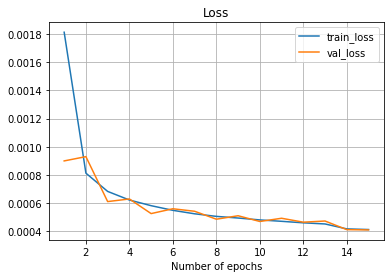

In [ ]:
plot_history(hist)

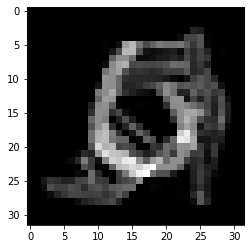

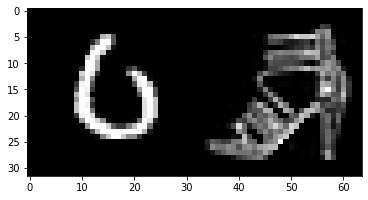

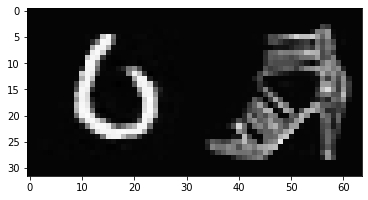

In [ ]:
x_batch, y_batch = next(test_generator)
x = x_batch[0]
y = y_batch[0]
y_pred = unet.predict(x.reshape((1,32,32)))
plt.imshow(x,cmap='gray', interpolation='nearest')
plt.show()
plt.imshow(y, cmap='gray', interpolation='nearest')
plt.show()
plt.imshow(y_pred[0].reshape((32,64)), cmap='gray', interpolation='nearest')
plt.show()

More training

In [18]:
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
reduce_lr_callback = ReduceLROnPlateau(monitor='val_loss', min_lr=0.000009, min_delta=0.0001, factor=0.75, patience=3, verbose=1, mode='min')
reduce_lr_callback = ReduceLROnPlateau(patience=3, min_delta=0.00001)

callback_checkpoint = ModelCheckpoint('UNET_diffImplementation.{epoch:02d}-{val_loss:.4f}.hdf5', save_weights_only=True) 

In [24]:
hist = unet.fit(train_generator, epochs=10, batch_size=batchsize, validation_data=test_generator, callbacks=[callback_checkpoint,reduce_lr_callback],
              steps_per_epoch=steps_per_epoch, validation_steps=val_steps)

Epoch 1/10
10000/10000 [==============================] - 443s 44ms/step - loss: 4.4324e-04 - val_loss: 4.6562e-04 - lr: 0.0010
Epoch 2/10
10000/10000 [==============================] - 443s 44ms/step - loss: 4.3691e-04 - val_loss: 4.3600e-04 - lr: 0.0010
Epoch 3/10
10000/10000 [==============================] - 443s 44ms/step - loss: 4.2948e-04 - val_loss: 4.2685e-04 - lr: 0.0010
Epoch 4/10
10000/10000 [==============================] - 442s 44ms/step - loss: 4.2429e-04 - val_loss: 4.4549e-04 - lr: 0.0010
Epoch 5/10
10000/10000 [==============================] - 443s 44ms/step - loss: 4.2182e-04 - val_loss: 4.3668e-04 - lr: 0.0010
Epoch 6/10
10000/10000 [==============================] - 443s 44ms/step - loss: 3.9255e-04 - val_loss: 3.8768e-04 - lr: 1.0000e-04
Epoch 7/10
10000/10000 [==============================] - 443s 44ms/step - loss: 3.8825e-04 - val_loss: 3.8504e-04 - lr: 1.0000e-04
Epoch 8/10
10000/10000 [==============================] - 443s 44ms/step - loss: 3.8444e-04 - va

In [25]:
test_generator1 = datagenerator(mnist_x_test, fashion_mnist_x_test, 20000)
mse_list = []
for i in range(10):
  x_batch, y_batch = next(test_generator1)
  mse = unet.evaluate(x_batch, y_batch)
  mse_list.append(mse)
print(mse_list)
print('Min:', min(mse_list))
print('Mean:', np.mean(mse_list))
print('Std:', np.std(mse_list))

625/625 [==============================] - 6s 9ms/step - loss: 3.8799e-04
[0.00038230890640988946, 0.00038314433186315, 0.00038679767749272287, 0.00038195919478312135, 0.0003840862773358822, 0.0003869114734698087, 0.0003857334377244115, 0.000384419021429494, 0.0003834088274743408, 0.0003879856667481363]
Min: 0.00038195919478312135
Mean: 0.0003846754814730957
Std: 1.9728312092440505e-06


Min: $3.8e-4$. Mean: $3.8e-4$. Std: $1.9e-6$.

**Better scores!!!**

In [26]:
import matplotlib.pyplot as plt
def plot_history(training_history, n_epochs=None):
    if not n_epochs:
      n_epochs = len(training_history.history['loss'])

    epochs = range(1,n_epochs+1)

    plt.plot(epochs, training_history.history['loss'], label='train_loss')
    plt.plot(epochs, training_history.history['val_loss'], label='val_loss')
    plt.legend()
    plt.grid()
    plt.xlabel('Number of epochs')
    plt.title('Loss')

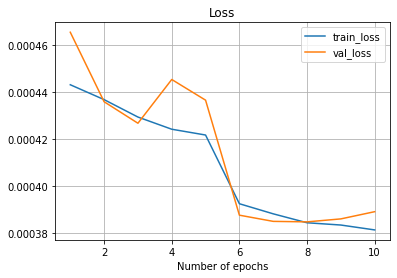

In [27]:
plot_history(hist)